<a href="https://colab.research.google.com/github/uumami/workshop_riskmathics/blob/main/deteccion_de_fraude.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deteccion de Fraude

El objetivo de este proyecto es comparar varios modelos de clasificacion en la deteccion de fraude en transacciones.

# Definicion del Problema

Utilizaremos los datos de Kaggle: https://www.kaggle.com/mlg-ulb/creditcardfraud

Para nuestro proyecto definiremos con valor 1 ($y=1$) cuando la traduccion fue fraudulenta, y 0 ($y=0$) en otro caso.  

LOs datos contienen transacciones de tarjetas de credito de Septiembre 2013, todas de peronas que viven en Europa. En total tenemos acceso a 2 dias de transacciones, donde hubo un total de 284k transacciones con 492 fraudes. Los fraudes solo representan el **.172%** del total de transacciones.  

El task es predecir el fraude. La variable `Class` es nuestro target ($y$). Las variables ya han sido preprocesadas con PCA para mantener anonimato, por lo que es algo dificil de interpretarlas directamnte.

# Librerias

In [1]:
# Load libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD

#Libraries for Saving the Model
from pickle import dump
from pickle import load

In [2]:
import warnings
warnings.filterwarnings('ignore')

# ETL

Carguemos la funcion de pandas
[pd.read_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)

In [3]:
df= read_csv('https://github.com/uumami/workshop_riskmathics/blob/main/creditcard.csv.zip?raw=true',
              compression='zip')


 Veamos su dimension

In [4]:
df.shape

(284807, 31)

Veamos su informacion general

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

En este caso no tuvimos muchos problemas, pues la informacion ha sido pre-procesada previamente con PCA que es una tecnica de reduccion de dimensionalidad.

# Exploratory Data Analysis

In [6]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


**Balanceo de Y**

In [8]:
class_names = {0:'Not Fraud', 1:'Fraud'}
print(df.Class.value_counts().rename(index = class_names))

Not Fraud    284315
Fraud           492
Name: Class, dtype: int64


Podemos observar como nuestras clases estan extremadamente desbalanceadas, la mayoria no son fraude.

## Descripciones Visuales y Graficas

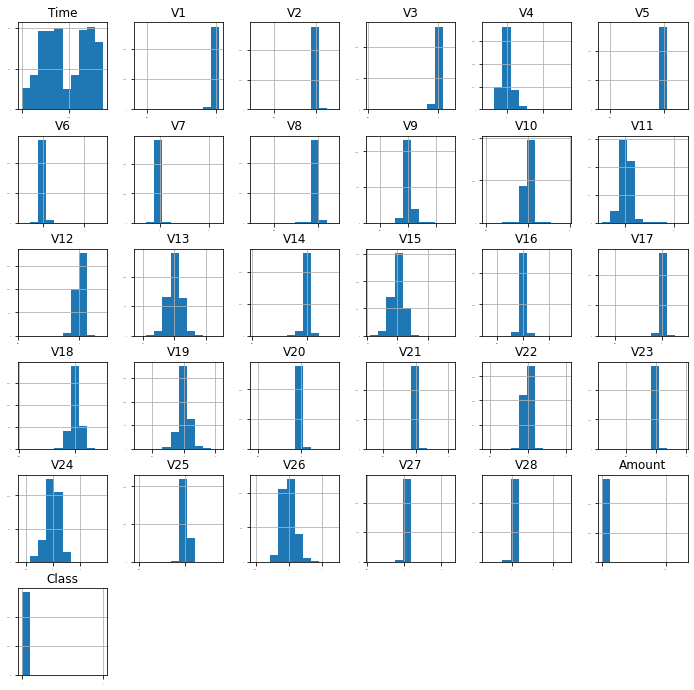

In [9]:
# histograms
df.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

Podemos observar que la distribucion de los datos esta sesgada. Pero, dado que no conocemos el significado de cada variable, es dificil tener una interpretacion.

In [10]:
df[['Time', 'Amount']].describe()

,Time,Amount
count,284807.000000,284807.000000
mean,94813.859575,88.349619
std,47488.145955,250.120109
min,0.000000,0.000000
25%,54201.500000,5.600000
50%,84692.000000,22.000000
75%,139320.500000,77.165000
max,172792.000000,25691.160000


La variable de `Time` parece ser altamente variable y tomar valores muy grandes.  
La variable `Amount` parece comportarse mejor y no variar tanto, aunque parece tener valores extremos. Observemos el percentil 75 y el max.

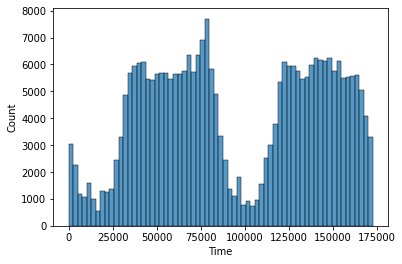

In [11]:
sns.histplot(x=df['Time'])

In [12]:
df['Time'].unique().shape

(124592,)

La variable `Time` contiene los segundos que pasaron entre la transaccion actual, y la primera transaccion del set de datos.

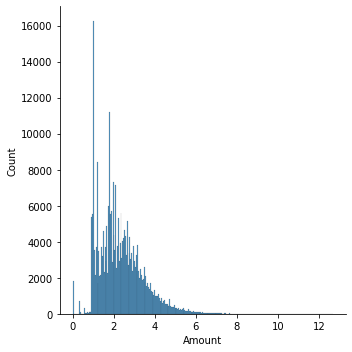

In [13]:
sns.displot(x=(np.power(df['Amount'], .25)))

## Preparacion de Datos

In [14]:
print('Null Values =',df.isnull().values.any())

Null Values = False


Por suerte no hay valores nulos en los datos!

# Split de datos

In [15]:
Y= df["Class"]
X = df.loc[:, df.columns != 'Class']
test_size = 0.25
seed = 7
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=test_size, random_state=seed)

print(f'Numero de fraudes en test: {Y_test.value_counts()}')
print(f'Numero de fraudes en train: {Y_train.value_counts()}')

Numero de fraudes en test: 0    71076
1      126
Name: Class, dtype: int64
Numero de fraudes en train: 0    213239
1       366
Name: Class, dtype: int64


Parece que los datos de fraude $y=1$ estan balanceados entre train y test.   
Sin embargo el total de datos esta desbalanceado. Por ahora, ignoraremos esto, y probaremos varios modelos. Despues ataqueremos este problema directamente, y compararemos resultados.

# Seleccion de Variables

Notebook de seleccion de variables: https://github.com/IEXE-Tec/aprendizaje-maquina-2/blob/master/01_seleccion_de_variables.ipynb 


Existen muchas tecnicas de estadistica clasica para Feature Selection ya sea tablas ANOVA, ANCOVA o diferentes tipos de correlacion para diferentes tipos de datos.

Post de [Feature Selection](https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/)

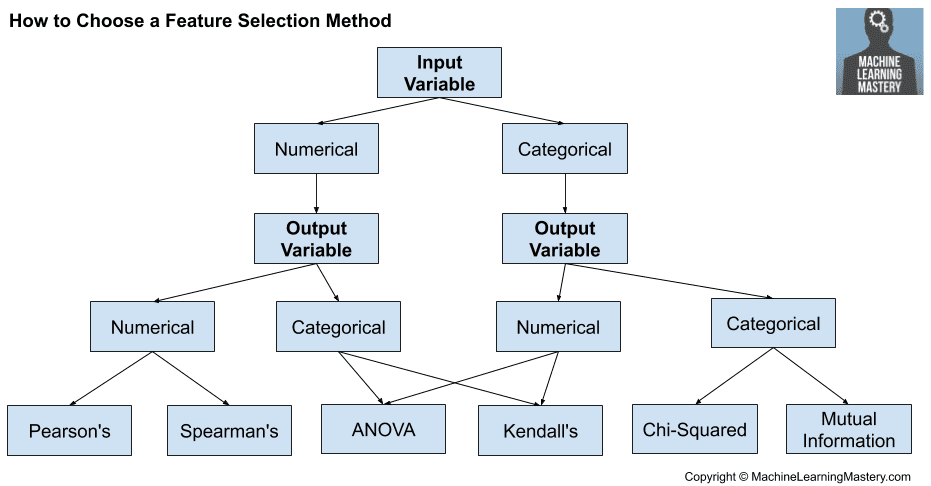

En nuestro caso nos saltaremos el **Feature Selection** para concentrarnos en los algoritmos y regularizacion.

El siguiente snippet contiene codigo de Kaggle para feature selection, utilizando Chi2. Aunque, esto no es del todo correcto, pues nuestras variables no son categoricas. Sin embargo, nos da una idea de la flexibilidad del ML.

In [18]:
# ## No ejecutar
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import chi2

# bestfeatures = SelectKBest( k=10)
# bestfeatures
# Y= df["Class"]
# X = df.loc[:, df.columns != 'Class']
# fit = bestfeatures.fit(X,Y)
# dfscores = pd.DataFrame(fit.scores_)
# dfcolumns = pd.DataFrame(X.columns)
# #concat two dataframes for better visualization 
# featureScores = pd.concat([dfcolumns,dfscores],axis=1)
# featureScores.columns = ['Specs','Score']  #naming the dataframe columns
# print(featureScores.nlargest(10,'Score'))  #print 10 best features

#Feature engineering

Escalemos las variables numericas. Las otras variables no necesitan escalamiento, pues dado que fueron sometidas a PCA fueron escaladas previamente.

**Nota**: En estricto sentido el escalamiento o normalizacion deberia hacerse en sobre el train set, y despues aplicarse al test set. Sin embargo, es muy comun aplicar el escalamiento a todo el data set, pensando que no producira **data leakage**.

+ Para la variable **time** utilizaremos [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html). Ahora la variable se encuentrara entre 0 y 1. Dado que **no parece tener outliers**, y distribuirse mas o menos uniforme.
+ Para **Amount** utilizaremos [RobustScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html). La variable es escalda con los rangos intercuantiles. Lo elegimos por el tipo de distribucion que que **tiene outliers**.

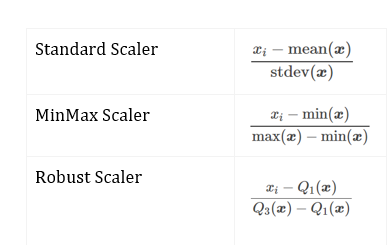

In [19]:
X_train['Time'].values.reshape(-1,1)

array([[140363.],
       [ 47351.],
       [123988.],
       ...,
       [ 44164.],
       [128493.],
       [ 49912.]])

In [20]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

# ##Time
time_scaler = MinMaxScaler().fit(X_train['Time'].values.reshape(-1,1))
# Entrenamos con train
X_train['time_scaled'] = time_scaler.transform(X_train['Time'].values.reshape(-1,1))
# Escalamos el test
X_test['time_scaled'] = time_scaler.transform(X_test['Time'].values.reshape(-1,1))

# ##Amount
amount_scaler = RobustScaler().fit(X_train['Amount'].values.reshape(-1,1))
# Entrenamos con train
X_train['amount_scaled'] = amount_scaler.transform(X_train['Amount'].values.reshape(-1,1))
# Escalamos el test
X_test['amount_scaled'] = amount_scaler.transform(X_test['Amount'].values.reshape(-1,1))

In [21]:
X_train[['time_scaled', 'amount_scaled']].describe()

,time_scaled,amount_scaled
count,213605.000000,213605.000000
mean,0.548390,0.923225
std,0.274779,3.343631
min,0.000000,-0.307091
25%,0.313001,-0.228643
50%,0.489490,0.000000
75%,0.806195,0.771357
max,1.000000,179.912479


In [22]:
X_test[['time_scaled', 'amount_scaled']].describe()

,time_scaled,amount_scaled
count,71202.000000,71202.000000
mean,0.549696,0.934937
std,0.274975,3.901089
min,0.000000,-0.307091
25%,0.315479,-0.230039
50%,0.493463,-0.000140
75%,0.806554,0.767867
max,0.999977,358.307649


In [23]:
X_train.drop(['Time', 'Amount'], axis=1, inplace=True)
X_test.drop(['Time', 'Amount'], axis=1, inplace=True)

# Modelaje

## Model Selection

Elijamos los Folds y los Modelos a utilizar

In [26]:
# test options for classification
num_folds = 5
seed = 7
# scoring ='f1'
scoring = 'accuracy'

# Modelos
models = []
models.append(('LR', LogisticRegression()))
#models.append(('ELN', LogisticRegression(penalty = 'elasticnet')))
models.append(('RF', RandomForestClassifier()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))

Ejecucion cercana a los 20 minutos!

In [27]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring,
                                 n_jobs=-1)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.999171 (0.000196)
RF: 0.999541 (0.000123)
LDA: 0.999354 (0.000113)
KNN: 0.999448 (0.000176)
CART: 0.999148 (0.000180)


## Balanceo con Undersampling

Ahora entrenaremos modelos usando el metodo de **Random Under Sampling**. Consiste en remover datos aleatoriamente de la clase que tiene mas valores. De esta manera, nuestros modelos no van a sobreajustar a la clase dominante. Pasos:
1. Determinar que tan imbalaceada estan nuestras clases (usar value counts)
2. Despues balancemos las clases sampleando de manera aleatoria la que tiene mas numeros. Normalmente se busca tener algo cercano al 50/50.
3. Entrenar y Evaluar con las clases balanceadas.  
El principal riesgo de esta tecnica es que podemos perder muchos datos, lo cual puede afectar el desempeño de nuestros modelos. Por ejemplo, pasamos de 280,315 datos de no fraude a 492.

Rebalanceo en el train

In [ ]:
df_train = pd.concat([X_train, Y_train], axis=1)
fraud_df = df_train.loc[df_train['Class'] == 1]
non_fraud_df = df_train.loc[df_train['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle de datos de nuevo
df_new = normal_distributed_df.sample(frac=1, random_state=42)
# split out validation dataset for the end
Y_train_new= df_new["Class"]
X_train_new = df_new.loc[:, dataset.columns != 'Class']


print('Distribution of the Classes in the subsample dataset')
print(df_new['Class'].value_counts()/len(df_new))
sns.countplot('Class', data=df_new)
pyplot.title('Equally Distributed Classes', fontsize=14)
pyplot.show()